# Step3 Prepare the datasets for indexing
--- 

## Semiannual geomidian data prepare

we will do the following pre-requests each time we want to use the cloud or kubenetes resources to process some datasets,

- Infrastructure As Cod (IAS) to define the resouce, such as AWS user/process name, AWS SQS queue name, AWS S3 bucket name et al,  which will be comsumed during the processing steps.
- `kubectl apply -f <config>.yaml`claim the resources from the definition
- `kubectl apply -f <job/pod>.yaml` consume the resources and finish the processing
- `kubectl delete -f <config>.yaml` release the k8s resources

---

### Update terraform script for new AWS resources
We will configure the AWS cloud resources for new datasets into the [processing Terraform file](https://bitbucket.org/geoscienceaustralia/datakube/src/master/workspaces/deafrica-dev/03_odc_k8s_apps/stats_procesing.tf).

Similarly, we will add two more yaml files into the [processing k8s configurations](https://bitbucket.org/geoscienceaustralia/datakube-apps/src/master/workspaces/deafrica-prod-af/processing/06_stats_gm.yaml) to claim the resource from k8s cluster.
  1. develop pod yaml
  2. `odc-stats run ...` k8s job yaml


### Collect the datasets through `odc-stats save-tasks` in develop pod

**Ask cloud techops to allow the access to our kubernetes cluster and the AWS EC2 dev instance to run `kubectl`.** Then, refer to out [kubenetes doc](https://docs.dev.dea.ga.gov.au/internal_services/eks/k8s_basics.html) to run following steps.


#### Get into dev pod
You will have defined the dev pod yaml in the `datakube-apps` repo. Run `kubectl get pods -n processing` to find the exact name of the pod in the list.

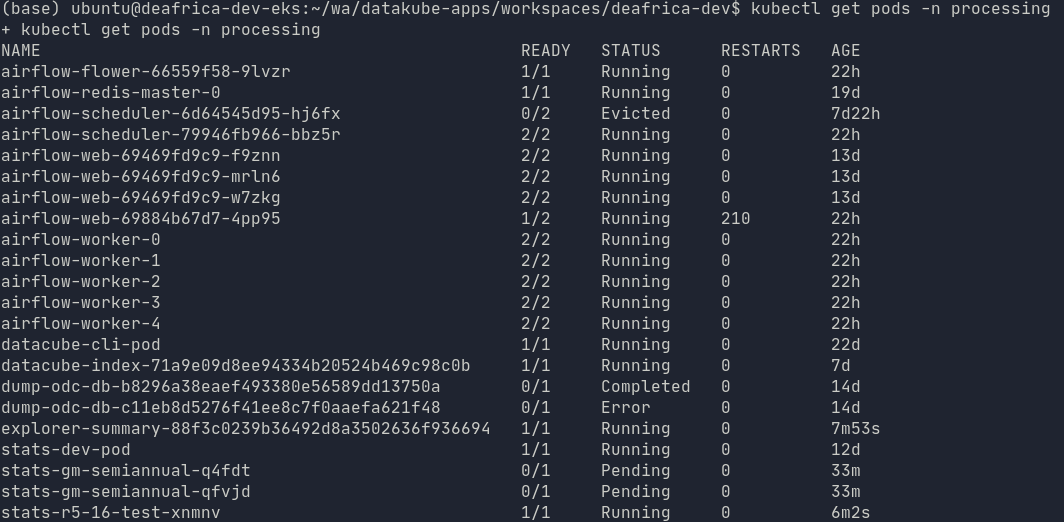

- run bash on the running container from `<dev pod>.yaml` in kubernetes
  ```bash
  # first
  kubectl apply -f 06_stats_semiannual_dev_pod.yaml -n processing
  # then
  kubectl exec -it stats-semiannual-dev-pod -n processing -- bash
  ```

- with latest version of `odc-stats` run 
  ```bash
  odc-stats save-tasks --frequency semiannual --grid africa-10 s2_l2a

   ```
- AWS S3 sync the task files on to the target s3 bucket
  ```bash
  aws s3 sync <result folder> s3://deafrica-data-dev-af/gm_s2_semiannual/0-1-0/
  ```
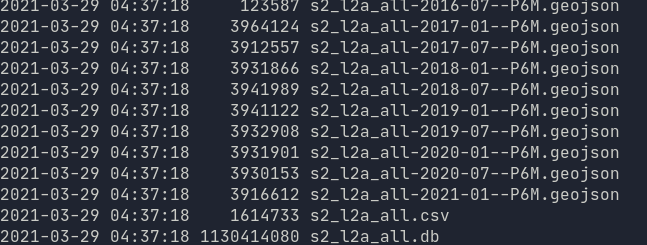
 
### Publish the tasks onto AWS SQS

After we have all task files synchronised onto s3, we can publish the some tasks to check the job ymal configurations.

- run the some largest dataset groups, such as top 4 largest as below
  ```bash

    odc-stats publish-tasks s3://deafrica-data-dev-af/gm_s2_semiannual/0-1-0/s2_l2a_all.db deafrica-dev-eks-stats-geomedian-semiannual 24322:24324
    odc-stats publish-tasks s3://deafrica-data-dev-af/gm_s2_semiannual/0-1-0/s2_l2a_all.db deafrica-dev-eks-stats-geomedian-semiannual 19964:19966
  
  ```
  
- After we lock down the configure file, we can run all data by publish selected data ranges 
  
- when the tasks were published onto AWS SQS, tasks will be processed automatically by applying the kubernetes job yaml file.

### Run the k8s job yaml

```bash
kubectl apply -f 06_stats_2019_semiannual_gm.yaml -n processing

```
Check the status with `kubectl get pods -n processing`,

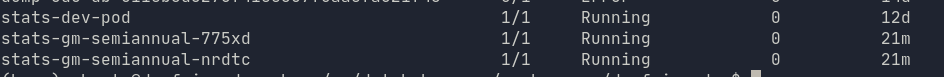

Check running reports from [Grafana](https://mgmt.dev.digitalearth.africa/)

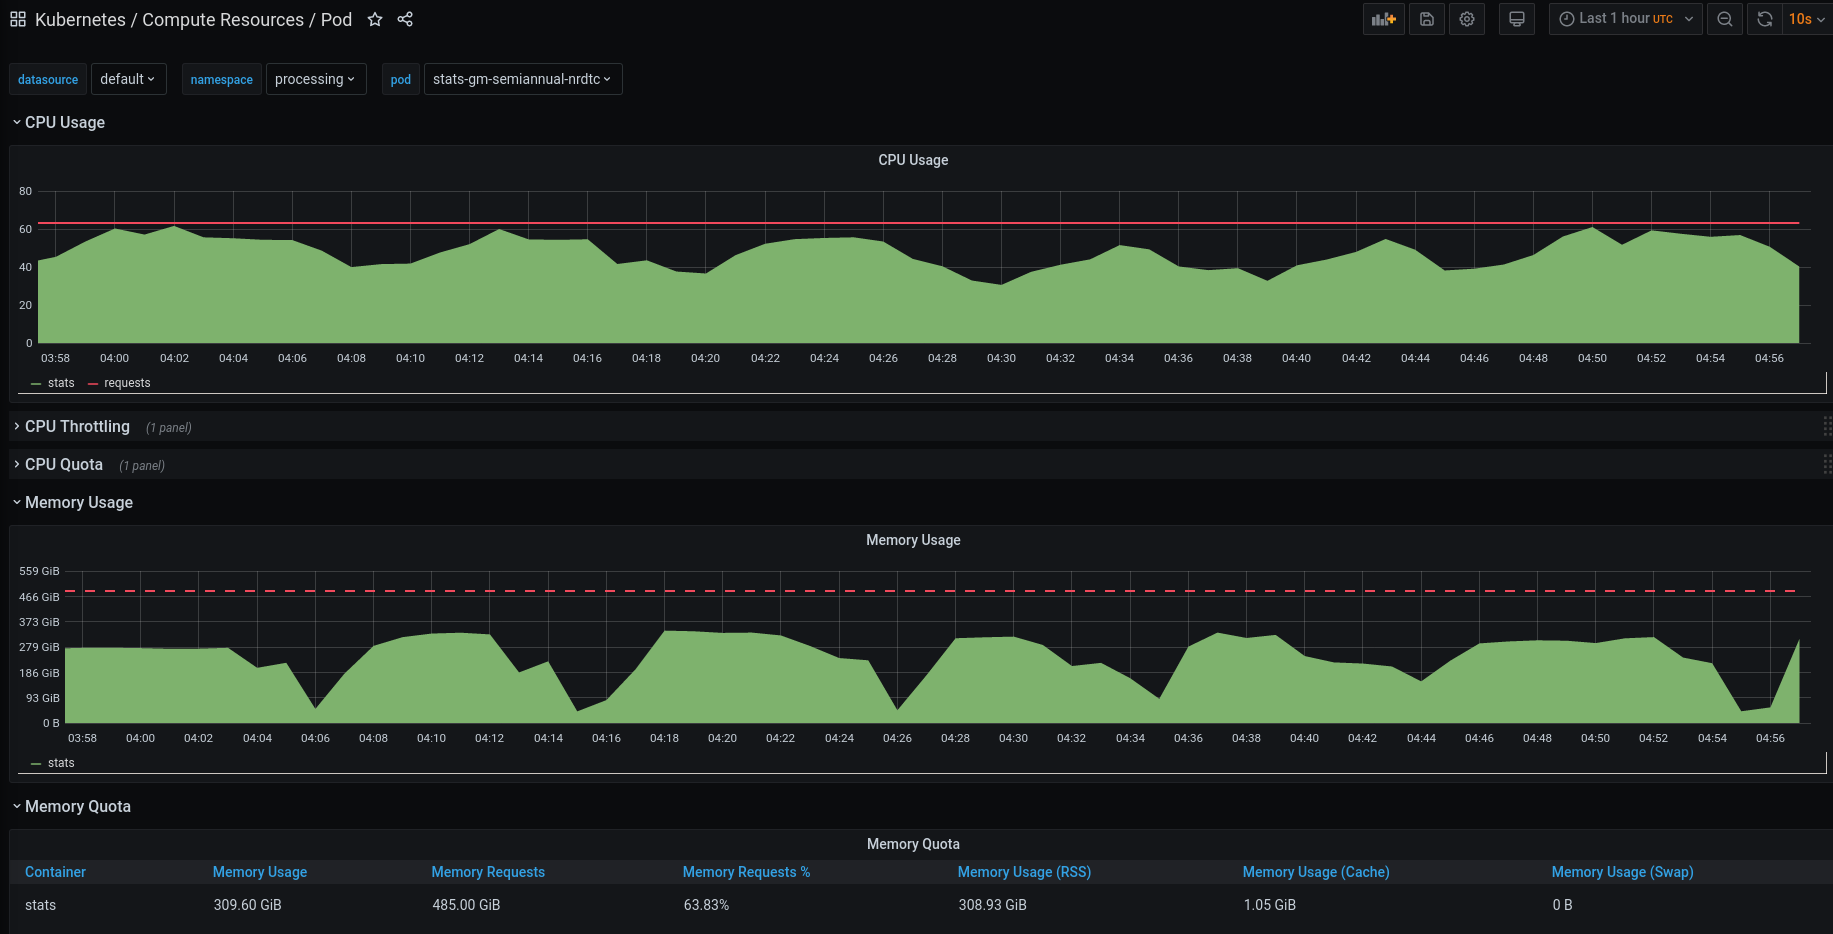

---

## Crop-mask prediction result 

AWS S3 data sync from Sandbox or devbox onto S3 buckets
We can use ```awscli``` to sync seed data into s3 to validate the s3 path as well as other setups.
The s3 url link of the stac json was also included in the stac json it self, like below

```json
"s3://deafrica-data-dev-af/crop_mask_eastern/v0.1.3/x048/y010/2019/crop_mask_eastern_x048_y010_2019.json"
```
The link parts include
1. bucket name
2. product name
3. product version
4. ```<x>/<y>``` tile index, the new indexing will be all positive value without sign. The relation ship are,
$$
x_{new} = x_{old}  + 181 \\
y_{new} = y_{old} + 77 \\
$$
5. time range, ```2019``` here is for the whole year. Otherwise, put something like, ```2019-01--P12M```, which was defined
  in the ```odc.stats.model.DatatimeRange```.

It is possible to use localstack to mock s3. But it needs extra tweaking.

Ideally, we do the mock s3 as below,
1. create the local mirror bucket

  ```bash
  aws s3 mb s3://deafrica-data-dev-af --endpoint-url=htp://192.168.0.19:4566
  ```

2. sync data onto the bucket
  ```bash
  aws s3 sync src/seed/v0.1.4 s3://deafrica-data-dev-af/crop_mask_eastern/v0.1.4 --endpoint-url=htp://192.168.0.19:4566 \
   --acl public-read
  ```
  
---

### Notes
Remember to add ``` --acl public-read``` when sync the data to real s3. Prepare the data in ```v0.1.4``` with the
exact folder structure as the s3 key prefix you want. Then, sync data,
  ```bash
  aws s3 sync v0.1.4/ s3://deafrica-data-dev-af/crop_mask_eastern/v0.1.4 --acl public-read
  ```
which just following the [aws s3 sync command](https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html).
  ```bash
  aws s3 sync <local data path> <remote s3 bucket and prefix> --acl public-read
  ```
Remember to delete the data recursively when you finished the testing.
  ```bash
  aws s3 rm --recursive s3://deafrica-data-dev-af/crop_mask_eastern
  ```